In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from datasets import load_dataset
import pandas as pd
import contractions
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
import numpy as np

2026-01-14 18:54:58.956976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 18:54:58.994935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 18:54:59.888569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/rooneyish/Applied_Machine_Learning/News_Article_Classification/.venv/lib/python3.11/s

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2026-01-14 18:55:00.132956: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-14 18:55:00.132978: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-14 18:55:00.132982: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-14 18:55:00.132985: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-14 18:55:00.132988: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: rooneyish
2026-01-14 18:55:00.132990: I external/local_xla/xla/stream_executor/cuda/cud

In [4]:
ds = load_dataset("sh0416/ag_news")

In [5]:
df = pd.concat([ds['train'].to_pandas(), ds['test'].to_pandas()])

In [6]:
df.sample(5)

,label,title,description
3476,3,Murdoch #39;to relaunch News deal #39; if los...,SYDNEY - Media mogul Rupert Murdoch said in a ...
74180,1,British Military Begins Deployment in Iraq,"British Army soldiers from the 1st Battalion, ..."
63728,3,Woolworths ordered to extend ALH takeover dead...,An independent takeovers panel has headed off ...
60684,1,Bush administration takes emergency steps to a...,AFP - US President George W. Bush's administra...
103466,2,"GOLDBERG ON FOOTBALL: Are the Eagles good, or ...",The Philadelphia Eagles clinched the NFC East ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        127600 non-null  int64 
 1   title        127600 non-null  object
 2   description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [8]:
df.shape

(127600, 3)

In [9]:
df.isnull().sum()

label          0
title          0
description    0
dtype: int64

In [10]:
df.dropna(inplace = True)

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
df = df.drop('title', axis = 1)
df.sample(5)

,label,description
104458,2,"Adelaide, November 29: Australia set New Zeala..."
58638,4,"Reuters - WebMD Corp. , a leading\provider of ..."
69198,3,Independent directors at Marsh McLennan have...
110004,2,Holders Porto survived a fightback to overcome...
14028,4,The increasing acidity of the world's oceans c...


In [14]:
df = df.rename(columns={'label': 'y', 'description': 'X'})
df.head()

,y,X
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [15]:
news_publishers = ['reuters', 'afp', 'ap', 'associated press', 'reuters news', 'bloomberg', 'cbc sports online']

def normalize_document(document):
    document = document.lower()
    document = contractions.fix(document)
    document = document.translate(str.maketrans('','',string.punctuation))
    for publisher in news_publishers:
        document = document.replace(publisher, '')
    document = " ".join(document.split())
    return document

In [16]:
df['X'] = df['X'].apply(normalize_document)

In [17]:
df.sample(5)

,y,X
84306,4,a director of technology for security outfit r...
56846,4,researchers trying to determine how the online...
58520,4,bill gates unveils plans to make media center ...
7000,4,when it comes to touting his companys software...
44524,1,haggard survivors of fighting in southern darf...


Text(0.5, 1.0, 'News Categories by No. of samples')

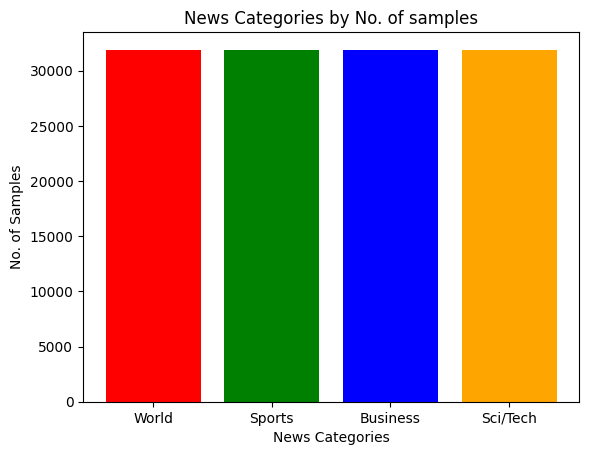

In [18]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.bar(class_names, df['y'].value_counts().sort_index(), color = ['red', 'green', 'blue', 'orange'])
plt.ylabel('No. of Samples')
plt.xlabel('News Categories')
plt.title('News Categories by No. of samples')

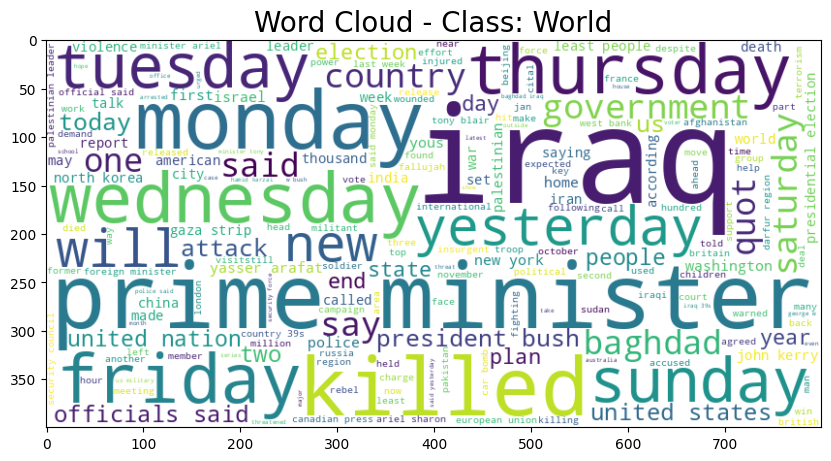

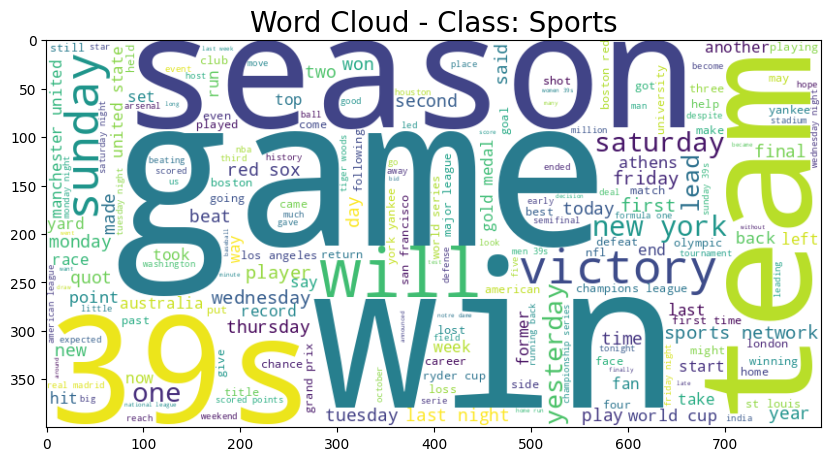

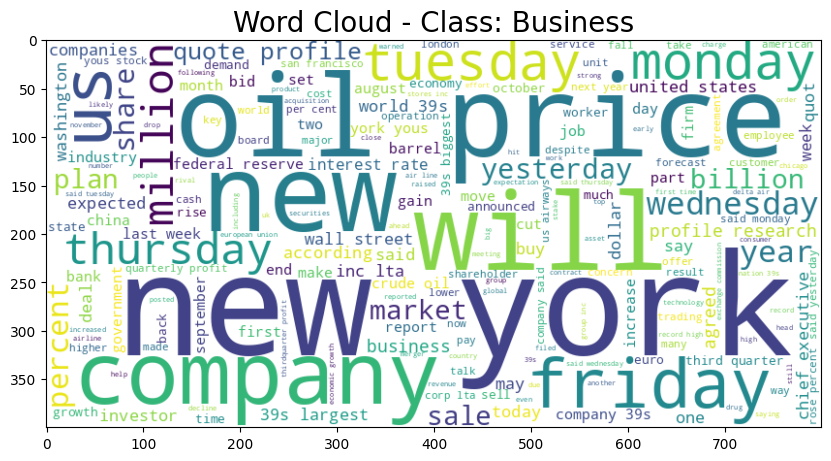

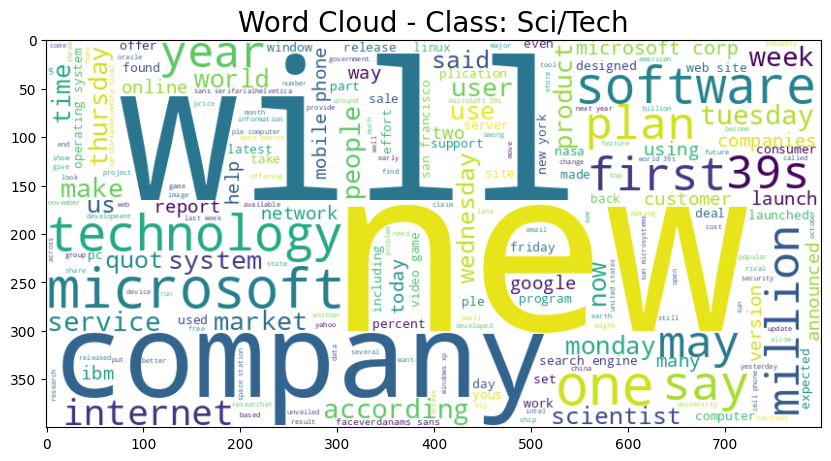

In [19]:
classes = sorted(df['y'].unique())

for category in classes:
    text_data = " ".join(df[df['y'] == category]['X'].astype(str))
        
    wc = WordCloud(
        width=800,
        height= 400,
        background_color='white',
        stopwords=set(STOPWORDS)
    ).generate(text_data)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    label_idx = int(category)-1
    plt.title(f'Word Cloud - Class: {class_names[label_idx]}', fontsize=20)

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(df['X'], df['y'], test_size=0.4, random_state=42, stratify=df['y'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [21]:
X_train.shape, X_val.shape, X_test.shape

((76560,), (25520,), (25520,))

In [22]:
tfidf = TfidfVectorizer()

In [23]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
tfidf.get_feature_names_out()[:20]

array(['00', '000', '000660se', '000th', '0013', '0013hk', '002', '004',
       '005', '005930ks', '007', '008', '009', '01', '010', '0100', '011',
       '01102004', '011104', '012'], dtype=object)

In [25]:
tfidf.vocabulary_

{'well': 72054,
 'we': 71802,
 'finally': 26186,
 'have': 30981,
 'an': 8056,
 'official': 46566,
 'introduction': 35234,
 'of': 46452,
 'both': 12803,
 'the': 66076,
 'giants': 28916,
 '39': 3249,
 'dualcore': 22472,
 'cpu': 18661,
 'power': 50890,
 'quotintel': 53382,
 'and': 8149,
 'amd': 7869,
 'must': 44186,
 'come': 17000,
 'to': 67204,
 'same': 57919,
 'conclusions': 17475,
 'earlier': 22770,
 'this': 66621,
 'decade': 19994,
 'since': 60503,
 'today': 67265,
 'seen': 59034,
 'server': 59388,
 'demonstrations': 20485,
 'with': 72862,
 '90nm': 5529,
 'chips': 15847,
 'from': 27838,
 'companies': 17178,
 'ketchup': 37249,
 'maker': 40668,
 'saw': 58223,
 'its': 35784,
 'profit': 51689,
 'fall': 25414,
 'as': 9264,
 'it': 35717,
 'spun': 62340,
 'off': 46504,
 'units': 69571,
 'del': 20318,
 'monte': 43367,
 'but': 13974,
 'new': 45055,
 'items': 35752,
 'boosted': 12696,
 'sales': 57827,
 'chicago': 15717,
 'manufacturer': 40954,
 'hj': 31972,
 'heinz': 31306,
 'co': 16595,
 'ple'

In [26]:
MNB_model = MultinomialNB()
MNB_model.fit(X_train_tfidf,y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [27]:
y_train_pred = MNB_model.predict(X_train_tfidf)
y_val_pred = MNB_model.predict(X_val_tfidf)
y_test_pred = MNB_model.predict(X_test_tfidf)

In [28]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score:.2f}")
print(f"Validation F1 Score: {val_f1_score:.2f}")
print(f"Test F1 Score: {test_f1_score:.2f} \n")

Train Accuracy: 91.36%
Validation Accuracy: 89.44%
Test Accuracy: 89.59% 

Train F1 Score: 0.91
Validation F1 Score: 0.89
Test F1 Score: 0.90 



In [29]:
y_train_dl = y_train- 1
y_val_dl = y_val - 1
y_test = y_test - 1

In [30]:
glove_path = 'glove.6B.100d.txt'

def load_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings(glove_path)

In [31]:
max_words = 20000
max_len = 100

In [32]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [33]:
X_train_pad[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   469,   515,   779,    27,
           21,   259,  5475,     4,   346,     1,   610,   117,  4157,
         9909,   437,     6,  1823,   811,    27,   568,     3,     1,
          594, 13737,   584,    37,  1438,   192,    79,   515,    27,
          872,   655,  7950,    11, 13738,   655,   995,    22,   346,
          162]], dtype=int32)

In [34]:
embedding_dim = 100
word_index = tokenizer.word_index
word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 'that': 9,
 '39s': 10,
 'with': 11,
 'as': 12,
 'is': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'it': 17,
 'by': 18,
 'has': 19,
 'new': 20,
 'an': 21,
 'from': 22,
 'his': 23,
 'will': 24,
 'was': 25,
 'after': 26,
 'have': 27,
 'be': 28,
 'their': 29,
 'are': 30,
 'over': 31,
 'he': 32,
 'us': 33,
 'two': 34,
 'but': 35,
 'first': 36,
 'this': 37,
 'more': 38,
 'monday': 39,
 'not': 40,
 'tuesday': 41,
 'wednesday': 42,
 'thursday': 43,
 'up': 44,
 'company': 45,
 'inc': 46,
 'friday': 47,
 'one': 48,
 'world': 49,
 'they': 50,
 'york': 51,
 'last': 52,
 'yesterday': 53,
 'against': 54,
 'than': 55,
 'were': 56,
 'who': 57,
 'about': 58,
 'into': 59,
 'year': 60,
 'been': 61,
 'president': 62,
 'out': 63,
 'yous': 64,
 'had': 65,
 'when': 66,
 'would': 67,
 'oil': 68,
 'corp': 69,
 'million': 70,
 'united': 71,
 'sunday': 72,
 'week': 73,
 'years': 74,
 'which': 75,
 'people': 76,
 'could': 77,
 'three'

In [35]:
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
model = Sequential([       
    Input(shape=(num_words,)),
    Embedding(num_words, 
              embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False), 
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax') 
])

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 100)     │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,740 (7.97 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [39]:
history = model.fit(X_train_pad, y_train_dl, epochs=10, batch_size=64, 
                    validation_data=(X_val_pad, y_val_dl))

Epoch 1/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8601 - loss: 0.4022 - val_accuracy: 0.8853 - val_loss: 0.3314
Epoch 2/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8891 - loss: 0.3186 - val_accuracy: 0.8969 - val_loss: 0.2964
Epoch 3/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.8970 - loss: 0.2968 - val_accuracy: 0.9014 - val_loss: 0.2933
Epoch 4/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9020 - loss: 0.2796 - val_accuracy: 0.9021 - val_loss: 0.2820
Epoch 5/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9070 - loss: 0.2647 - val_accuracy: 0.8992 - val_loss: 0.2924
Epoch 6/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.9113 - loss: 0.2523 - val_accuracy: 0.9054 - val_loss: 0.2789
Epoch 7/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.9150 - loss: 0.2424 - val_accuracy: 0.9062 - val_loss: 0.2746
Epoch 8/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.9183 -